In [1]:
import pandas as pd
import numpy as np
from metric import amex_metric_np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

In [18]:
truth_np_minority_indices = np.where(truth_np==1)
truth_np_majority_indices = np.where(truth_np==0)[:len(truth_np_majority_indices)]

truth_np_reduced = np.hstack((truth_np[truth_np_minority_indices], truth_np[truth_np_majority_indices]))
truth_np = truth_np_reduced

In [3]:
# Load Predictions
data = {
    'GBDT': pd.read_csv('results/preds_catboost.csv', index_col=0).to_numpy().flatten(),
    'CNN': pd.read_csv('results/preds_cnn.csv').to_numpy().flatten(),
    'FCN': pd.read_csv('results/preds_fcn.csv').to_numpy().flatten(),
}

In [17]:
# Reduce to balanced indices
for key in data.keys():
    data[key] = np.hstack((data[key][truth_np_minority_indices], data[key][truth_np_majority_indices]))

In [4]:
# & Ground Truth
truth_csv = 'results/test_y_ownsplit.csv' # Ground truth of our own validation split
truth_df = pd.read_csv(truth_csv, index_col=0)
truth_np = truth_df.to_numpy().flatten()

First, standard AMEX metric.

In [21]:
for method_name, method_arr in data.items():
    print(f'Metric for {method_name}: {amex_metric_np(truth_np, method_arr)}')

Metric for GBDT: 0.781752325648032
Metric for CNN: 0.7769457846180265
Metric for FCN: 0.7764877714601739


Then, ROC Curve.

AUROC for GBDT: 0.9590741512810189
AUROC for CNN: 0.9569581971825111
AUROC for FCN: 0.9567996361923539


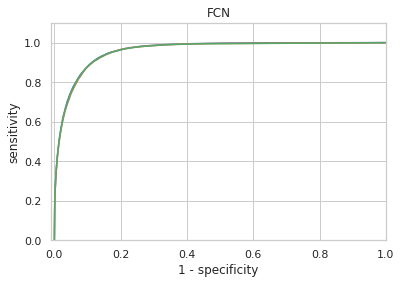

In [22]:
for idx, (method_name, method_arr) in enumerate(data.items()):
    operating_point = 0.0
    operating_point_step = 0.01
    sensitivities = []
    specificities = []

    while operating_point < 1.0:
        default_predictions = (method_arr > operating_point).astype(int)
        true_positives = np.count_nonzero((default_predictions == 1) & (truth_np == 1))
        true_negatives = np.count_nonzero((default_predictions == 0) & (truth_np == 0)) 
        false_positives = np.count_nonzero((default_predictions == 1) & (truth_np == 0)) 
        false_negatives = np.count_nonzero((default_predictions == 0) & (truth_np == 1)) 
        # Proportion of true positive predictions among all positives
        sensitivity = (true_positives / (true_positives + false_negatives))
        # Proportion of true negative predictions among all negatives
        specificity = (true_negatives / (true_negatives + false_positives))

        sensitivities.append(sensitivity)
        specificities.append(specificity)
        operating_point += operating_point_step
    # Correct start and end values
    sensitivities[-1] = 0
    specificities[-1] = 1
    sensitivities = np.array(sensitivities)
    specificities = np.array(specificities)

    
    plt.plot(1-specificities, sensitivities)
    plt.title(method_name)
    plt.ylabel('sensitivity')
    plt.xlabel('1 - specificity')
    plt.xlim(-.01,1)
    plt.ylim(0,1.1)
    plt.savefig(f'plots/results_roc_{method_name}.pdf')
    
    print(f'AUROC for {method_name}: {np.abs(np.trapz(sensitivities, x=1-specificities))}')

Now, prepare csv with categorical cross entropy and give it to R for further analysis

In [35]:
dfs = []
epsilon = 1e-9 # numerical stability
for method_name, method_arr in data.items():
    cross_entropy = -(truth_np*np.log(method_arr + epsilon) + (1 - truth_np)*np.log(1 - (method_arr - epsilon)))
    l1 = np.abs(truth_np - method_arr)
    #cross_entropy[cross_entropy>1]=1. # Clip values at 1
    #cross_entropy_one_minus = 1-cross_entropy
    #rms = np.sqrt((truth_np - method_arr)**2)
    df = pd.DataFrame(np.dstack((truth_np, method_arr, cross_entropy, l1, [method_name] * len(method_arr))).squeeze(), columns=['true', 'pred', 'cross_entropy', 'l1', 'method'])
    df['cross_entropy'] = df['cross_entropy'].astype(np.float64)
    dfs.append(df)

In [36]:
df = pd.concat(dfs)
df.to_csv('results/preds_processed_for_challenger.csv')

In [34]:
df.cross_entropy_one_minus.astype(np.float64).max()

AttributeError: 'DataFrame' object has no attribute 'cross_entropy_one_minus'

In [28]:
rms

array([4.6016600e-03, 4.0517140e-01, 9.2616574e-01, ..., 3.0364661e-05,
       3.6544637e-03, 1.9089799e-01])